Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


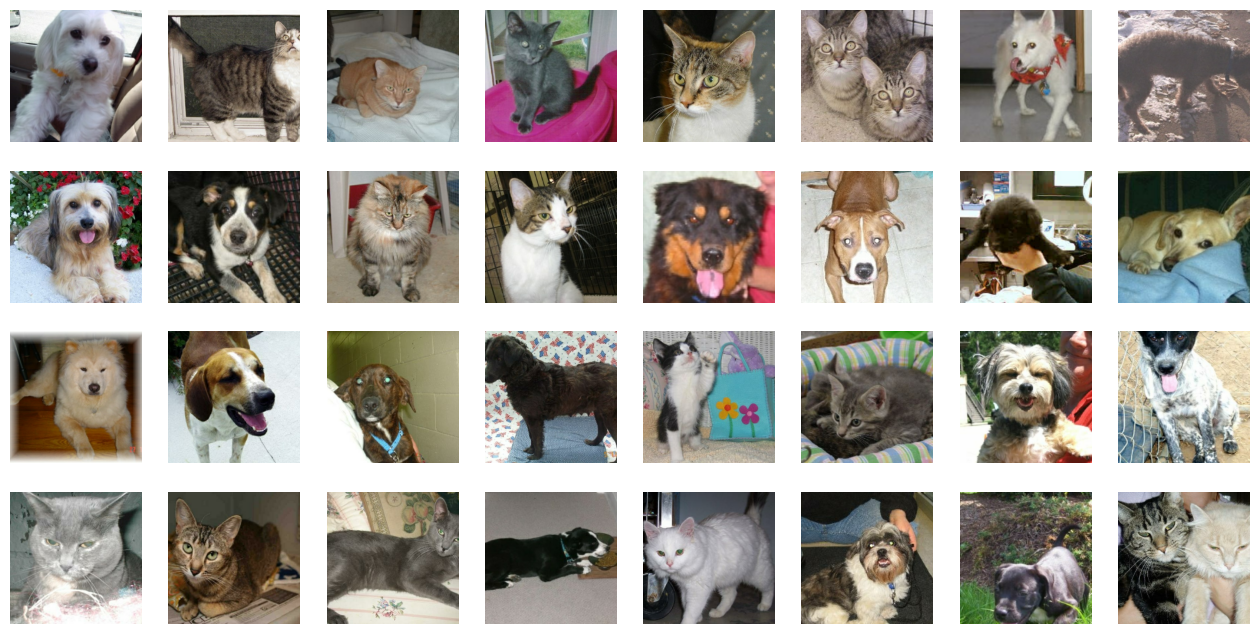

In [1]:
import json
import math
import numpy as np
import matplotlib.pyplot as plt
import os
import keras
from keras import losses
from keras import ops
from keras import optimizers
from keras.optimizers import schedules
from keras import metrics
from keras.applications.imagenet_utils import decode_predictions
import keras_hub
import tensorflow as tf
import tensorflow_datasets as tfds

os.environ["KERAS_BACKEND"] = "jax"

BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE
tfds.disable_progress_bar()

data, dataset_info = tfds.load("cats_vs_dogs", with_info=True, as_supervised=True)
train_steps_per_epoch = dataset_info.splits["train"].num_examples // BATCH_SIZE
train_dataset = data["train"]

num_classes = dataset_info.features["label"].num_classes

resizing = keras.layers.Resizing(
    IMAGE_SIZE[0], IMAGE_SIZE[1], crop_to_aspect_ratio=True
)


def preprocess_inputs(image, label):
    image = tf.cast(image, tf.float32)
    # Staticly resize images as we only iterate the dataset once.
    return resizing(image), tf.one_hot(label, num_classes)


# Shuffle the dataset to increase diversity of batches.
# 10*BATCH_SIZE follows the assumption that bigger machines can handle bigger
# shuffle buffers.
train_dataset = train_dataset.shuffle(
    10 * BATCH_SIZE, reshuffle_each_iteration=True
).map(preprocess_inputs, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)

images = next(iter(train_dataset.take(1)))[0]

# Define a function to plot an image gallery
def plot_image_gallery(images, num_rows=4, num_cols=8):
    """Plots a gallery of images."""
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].numpy().astype("uint8"))
        ax.axis("off")
    plt.show()

plot_image_gallery(images)

In [2]:
model = keras_hub.models.ImageClassifier.from_preset(
    "resnet_v2_50_imagenet", num_classes=2
)
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    metrics=["accuracy"],
)

100%|██████████| 840/840 [00:00<00:00, 1.20MB/s]


100%|██████████| 3.54k/3.54k [00:00<00:00, 5.21MB/s]


100%|██████████| 98.1M/98.1M [00:00<00:00, 128MB/s]


100%|██████████| 90.2M/90.2M [00:00<00:00, 121MB/s]


In [3]:
model.fit(train_dataset)

727/727 ━━━━━━━━━━━━━━━━━━━━ 4448s 6s/step - accuracy: 0.5049 - loss: 7.8631


In [5]:
predictions = model.predict(images)

classes = {0: "cat", 1: "dog"}
print("Top class is:", classes[predictions[0].argmax()])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Top class is: cat
